# Sky model tutorial

Most quantities in the sky model interface is `astropy.unit.Quantity` objects

In [1]:
import astropy.units as u

## Initialize a sky model

There are two ways to initialize the Cosmoglobe Sky Model. The default way is to use the ``cosmoglobe.skymodel`` function, which by default downloads and cache a HDF5 file containing the model data (for a specific NSIDE).

Alternatively, we can use ``cosmoglobe.model_from_chain`` if we have direct access to a commander3 chain.

### Using ``cosmoglobe.skymodel`` (currently unavailable)

This method is currently unavailable as we are working on producing the first stable data release. As a result the below code will not function as of now.

In [16]:
# from cosmoglobe import skymodel
# model = skymodel(nside=256)

### Using ``cosmoglobe.model_from_chain``

This method initializes a model directly from a commander3 HDF5 chainfile.

In [34]:
from cosmoglobe import model_from_chain

# Path to commander3 chainfile
chain = "/Users/metinsan/Documents/doktor/Cosmoglobe_test_data/chain_test.h5"

# Initializing the Cosmoglobe Sky Model at NSIDE 256
model = model_from_chain(chain, nside=256)

Loading components from chain
Done: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s] 


To get an overview of the model and the sky components in it, we can print the model object:

In [4]:
model

Model(
  nside: 256
  components( 
    (ame): AME(nu_p)
    (cmb): CMB()
    (dust): Dust(beta, T)
    (ff): FreeFree(Te)
    (radio): Radio(specind)
    (synch): Synchrotron(beta)
  )
)

We can disable any component in the model with the `model.disable()` function:

In [35]:
model.disable('radio')
model

Model(
  nside: 256
  components( 
    (ame): AME(nu_p)
    (cmb): CMB()
    (dust): Dust(beta, T)
    (ff): FreeFree(Te)
    (synch): Synchrotron(beta)
  )
)

And re-enable them using the `model.enable` function:

In [36]:
model.enable('radio')

## Model components

Let us explore the sky components in further detail. Each component can be individually accessed through the attribute names seen in the ``print(model)`` output.

In [20]:
print(model.dust, model.synch) # Etc..

Dust(beta, T) Synchrotron(beta)


### Component attributes

The model data is stored in the following component attributes:

- `amp`: Amplitude map at the reference frequency (Commander average posterior map)

- `freq_ref`: Reference frequency of `amp`

- `spectral_parameters`: A dictionary containing the spectral parameters

We can print these attributes:

In [6]:
print(model.dust.amp)
print(model.dust.freq_ref)
print(model.dust.spectral_parameters)

[[30.309875   -0.4310924   8.452302   ...  6.667059    9.971937
  11.81585   ]
 [-4.019577   -1.2983557   1.6992227  ...  4.3319874  -5.6275396
   0.72578835]
 [ 2.6104844   2.118119   -0.9043058  ... -6.7324114   0.4760493
   0.7606246 ]] uK
[[545.]
 [353.]
 [353.]] GHz
{'beta': <Quantity [[1.5476462],
           [1.5766188],
           [1.5766188]]>, 'T': <Quantity [[17.331007],
           [17.331007],
           [17.331007]] K>}


### Visualizing component maps

We can visualize the maps of a component (`amp` or a spectral parameter map) using `healpy.mollview`. 

Alternatively, we can use `cosmoglobe.plot`, which is a wrapper on healpy's mollview function that features built-in esthetique choices. 

In this tutorial we will use `cosmoglobe.plot`. For a more in in-depth overview of the built-in plot function, please see the Plotting tutorial.

In [ ]:
from cosmoglobe import plot

Lets plot some of the reference amplitude maps that the model uses:

Applying semi-logscale
Colormap: sunburst


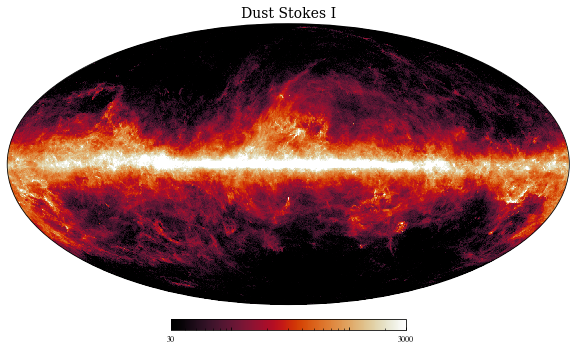

In [7]:
dust_amp_I = model.dust.amp[0]  # Stokes I map of dust

plot(
    dust_amp_I,
    title='Dust Stokes I',
    min=30,
    max=3000,
    norm='log',
    cmap='sunburst',
)

Applying semi-logscale
Colormap: iceburn


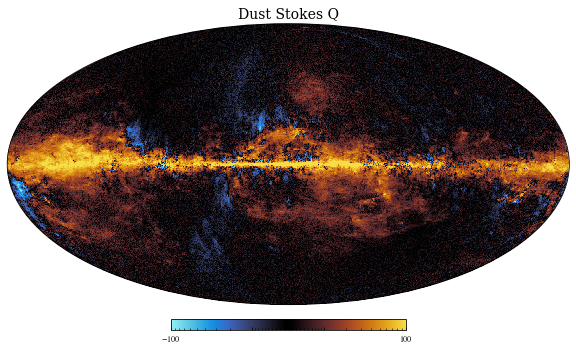

In [8]:
dust_amp_Q = model.dust.amp[1]  # Stokes Q map of dust

plot(
    dust_amp_Q,
    title='Dust Stokes Q',
    min=-100,
    max=100,
    norm='log',
    cmap='iceburn',
)

## Simulations

We can simulate the emission from a component at an arbitrary frequency `freq` by calling the component's `__call__` method, e.g `model.dust(freq)`:

Colormap: swamp


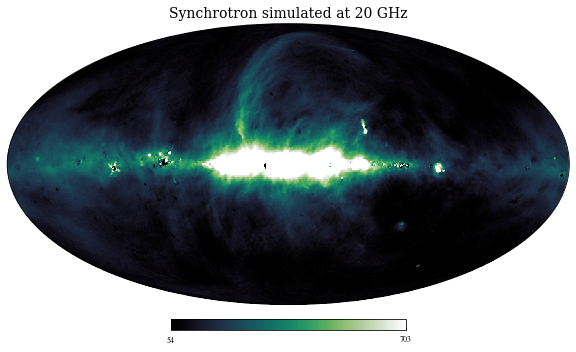

In [24]:
# Simulated synchrotron emission at 20GHz
synch_20GHz = model.synch(20*u.GHz)[0]

plot(
    synch_20GHz, 
    title='Synchrotron simulated at 20 GHz', 
    cmap='swamp',
)

The `__call__` function takes in the following key word arguments:

- `freqs` : A frequency, or a list of frequencies for which to evaluate the sky emission.
- `bandpass` : Bandpass profile corresponding to the frequencies (optional). 
- `fwhm` : The full width half max parameter of the Gaussian used to smooth the output (optional).
- `output_unit` : The output units of the emission (By default the output unit of the model is always in uK_RJ

Colormap: freeze


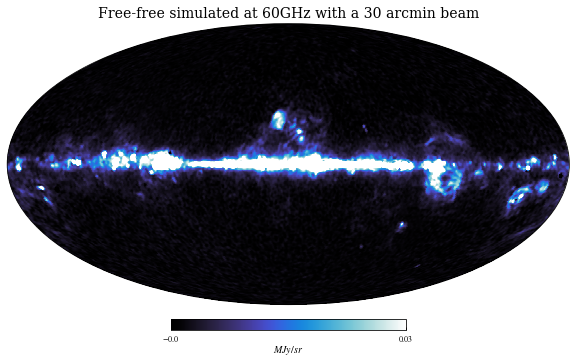

In [9]:
# Simulated free free emission at 60GHz seen by a 30 arcmin beam in units of MJy/sr
emission = model.ff(60*u.GHz, fwhm=30*u.arcmin, output_unit='MJy/sr')[0]

plot(
    emission, 
    title=f'Free-free simulated at 60GHz with a 30 arcmin beam', 
    unit=ff_60GHz,
    cmap='freeze',
)

## Full sky model emission 

Similarly, by calling the model's `__call__` function (which takes in the same keyword arguments), we can simulate the sky emission over the full model at a given frequency:

100%|██████████| 12192/12192 [00:02<00:00, 4642.03it/s]
Smoothing diffuse emission
Colormap: planck


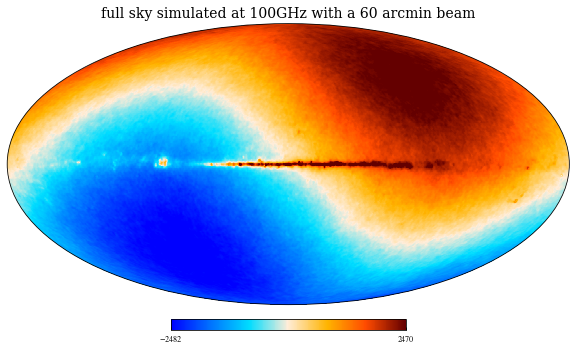

In [10]:
# Simulated full sky emission at 100GHz seen by a 60 arcmin beam in units of uK_RJ
emission = model(100*u.GHz, fwhm=60*u.arcmin)[0]

plot(
    emission, 
    title='full sky simulated at 100GHz with a 60 arcmin beam',  
    min=-3400,
    max=3400,
    norm='hist',
)


It is possible to remove the solar dipole from the model, by calling `model.cmb.remove_dipole()`:

100%|██████████| 12192/12192 [00:02<00:00, 4864.39it/s]
Smoothing diffuse emission
Colormap: planck


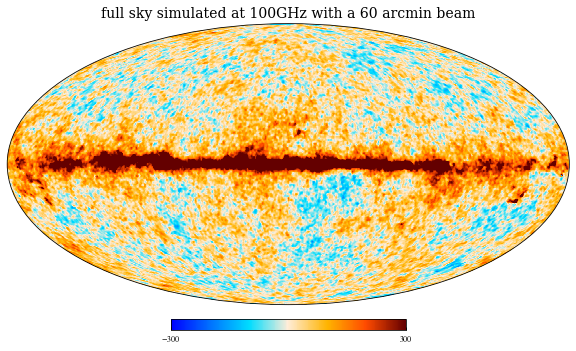

In [11]:
# Remove the solar dipole
model.cmb.remove_dipole()

# Simulated full sky emission at 100GHz seen by a 60 arcmin beam in units of uK_RJ
fullsky_emission_100GHz = model(100*u.GHz, fwhm=60*u.arcmin)[0]

plot(
    fullsky_emission_100GHz, 
    title='full sky simulated at 100GHz with a 60 arcmin beam', 
    min=-300,
    max=300,
)


## Bandpass integration

We can also make simulations that have integrated the sky emission over a given bandpass. By default 
if only a list of frequencies are supplied without a explicit bandpass, a top-hat bandpass will be assumed.

Smoothing diffuse emission
Colormap: planck


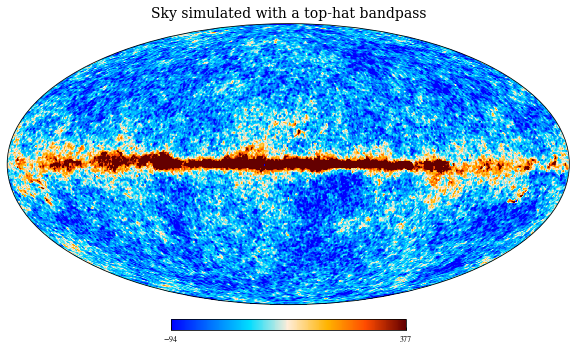

In [26]:
import numpy as np

frequencies = np.arange(100, 110, 50)*u.GHz

emission = model(frequencies, fwhm=40*u.arcmin)

plot(
    emission, 
    title='Sky simulated with a top-hat bandpass', 
    norm='hist',
)

In the following we use the WMAP K-band bandpass profile:

In [29]:
bandpass = "/Users/metinsan/Documents/doktor/Cosmoglobe_test_data/wmap_bandpass.txt"
frequencies, bandpass, _ = np.loadtxt(bandpass, unpack=True)

#add astropy units to the bandpass
frequencies*= u.GHz
bandpass *= u.K

Smoothing diffuse emission
Colormap: planck


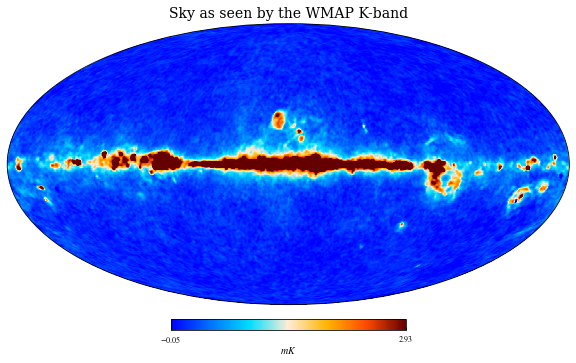

In [30]:
# Note: Solar dipole is removed from the model
wmap_kband_emission = model(frequencies, bandpass, fwhm=0.88*u.deg, output_unit='mK')[0]

plot(
    wmap_kband_emission, 
    title='Sky as seen by the WMAP K-band', 
    unit=wmap_kband_emission.unit,
    norm='hist',
)

### Point sources

The radio component does not internally store amplitude maps, but rather just a single amplitude value estimated in commander per point source. Each source is mapped to a healpix map with a gaussian beam whenever the model (or radio component) is called.

100%|██████████| 12192/12192 [00:02<00:00, 5072.83it/s]
Applying semi-logscale
Colormap: CMRmap


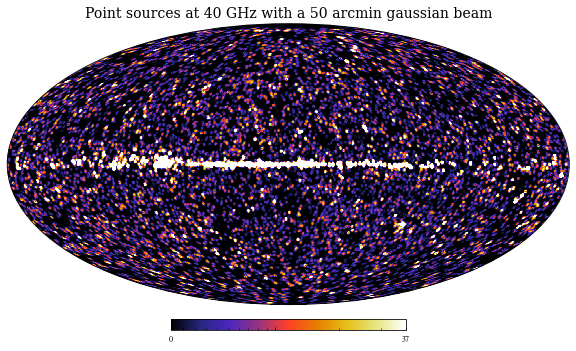

In [31]:
# Point sources seen at 40GHz over a 50 arcmin gaussian beam
emission = model.radio(30*u.GHz, fwhm=50*u.arcmin)[0]

plot(
    emission, 
    title='Point sources at 40 GHz with a 50 arcmin gaussian beam', 
    norm='log', 
    cmap='CMRmap'
)